## Age Detection

__Dataset__ : The dataset consists of images(feature) of indian actors and their age(label) as label. And here we're gonna predict age of an actor from his/her image. For this purpose we're gonna use keras, pandas, numpy and convolutional neural network. 

## <b>Step 1 </b>: Import all the required libraries 

<b>We are going to use following libraries::</b>

* __1. Pandas__  --> To import dataset in the form of dataframe
* __2. Numpy__ --> To easily handel complex computations
* __3. Sklearn__ --> To easily handel machine learning operations
* __4. Keras__ --> To easily implement comvolutional neural network
* __5. Pickle__ --> To save our model
* __6. Seaborn__ --> For ploting 

In [2]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
from PIL import Image
from keras.utils import np_utils
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## <b>Step 2 </b> : Extract all the required data and combine it

Set path to extract iamges and store them into a list 'images'.

In [3]:
path = 'dataset/train/Train/'
images = !ls {path}
# images

In [4]:
images[0]

'0.jpg'

Import the CVS file containing name of the images and its labels (age).

In [5]:
train_labels = pd.read_csv('dataset/train/train.csv')
train_labels.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [6]:
train_labels.shape

(19906, 2)

Here we can see that labels are categorised into 3 groups
* OLD
* MIDDLE 
* YOUNG

In [7]:
outputs = list((train_labels['Class']).unique())
outputs

['MIDDLE', 'YOUNG', 'OLD']

Here we can see the distrbution of the data

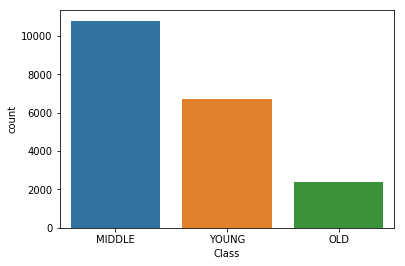

In [8]:
sb.countplot(train_labels.Class, data = train_labels)

Data_combiner will -
* __Resize the images__  
* __assign proper label to the array form of an image__ 

and return feature and label in the form of array

In [9]:
class data_Label_Combiner:

    def Data_combiner(self,images, labels, path):
        x_train=[]
        y_train=[]
        for each in images:
            x_train.append(np.asarray(Image.open(path+each).resize((64,64)), dtype='int32'))
            y_train.append(np.asarray(labels[labels['ID']==each]['Class']))
        return np.array(x_train), np.array(y_train)

In [10]:
# Create object of data_Label_Combiner class as 'dlc'
dlc = data_Label_Combiner() 

In [11]:
# Using object of class data_Label_Combiner call method Data_combiner
x_train, y_train = dlc.Data_combiner(images, train_labels, path)

## Step 3 : Data Preprocessing

As our labels are in categorical form we need to apply one hot encoding on it, so that it'll get converted into numerical form. 
For this we'll have to convert string data into numerical format by assigning numerical value to each unique element, because sklearn supports one hot encoding only for data in numerical format. 

In [12]:
le = LabelEncoder()

In [13]:
le.fit(y_train)

LabelEncoder()

In [14]:
y_train

array([['MIDDLE'],
       ['MIDDLE'],
       ['YOUNG'],
       ...,
       ['YOUNG'],
       ['YOUNG'],
       ['OLD']], dtype=object)

In [15]:
y_train = le.transform(y_train)
y_train

array([0, 0, 2, ..., 2, 2, 1])

In [16]:
y_train = np_utils.to_categorical(y_train)
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

## Step 4 :  Split the data into train and test set
Here we are using train_test_split method from sklearn library

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size = 0.1)

In [18]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((17915, 64, 64, 3), (1991, 64, 64, 3), (17915, 3), (1991, 3))

## Step : Define the structure of neural network

The Sequential model is a linear stack of layers.

Create an object ( 'clasifier' ) of Sequential model from sklearn 

In [19]:
classifier = Sequential()

Add layers to the neural network using .add method

The model needs to know what input shape it should expect. For this reason, the first layer in a Sequential model (and only the first, because following layers can do automatic shape inference) needs to receive information about its input shape

In [20]:
classifier.add(Convolution2D(32,3,3, input_shape=(64,64,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Convolution2D(32,3,3, activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Flatten())

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
classifier.add(Dense(activation='relu', output_dim = 100))
classifier.add(Dense(output_dim = 3, activation='softmax'))

Before training a model, you need to configure the learning process, which is done via the compile method

In [22]:
classifier.compile(metrics=['accuracy'], loss='binary_crossentropy', optimizer='adam' )

ImageDataGenerator used for augmentation of images according to parameters

In [23]:
train_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.3,
    rescale=1.0/255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

255 is the maximin pixel value. Rescale 1./255 is to transform every pixel value from range [0,255] -> [0,1].

In [24]:
val_generator = ImageDataGenerator(rescale=1.0/255)

fit_generator will load the data into RAM and perform training on batches using epochs that we have provided as parameters

In [25]:
classifier.fit_generator(train_generator.flow(x_train,y_train,batch_size=32)
                        , steps_per_epoch=len(x_train)
                        , epochs=1
                        ,validation_data=val_generator.flow(x_test,y_test,batch_size=32)
                        ,validation_steps=len(x_test))

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
17915/17915 [==============================] - 2220s 124ms/step - loss: 0.4303 - acc: 0.7984 - val_loss: 0.3556 - val_acc: 0.8400


In [26]:
classifier.evaluate(x_test ,y_test)

1991/1991 [==============================] - 2s 769us/step


[4.485825699576776, 0.7130420310062598]

Predict the values for test data

In [27]:
y_pred = classifier.predict_classes(x_test)

In [36]:
with open('model.pkl','wb') as f:
    pickle.dump(classifier,f)